### imports

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import torch
import torch.nn as nn

import gradio as gr

c:\Users\laphouse\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### load data

In [19]:
# Load dataset
digits = load_digits()
X, y = digits.data, digits.target

print(X.shape)  
print(y.shape) 

(1797, 64)
(1797,)


### `EDA`

In [20]:
images = digits.images  # each is 8 x 8 pixel and flattened into 64 feature

In [26]:
# basic dimensions checking
print("Shapes:")
print("Feature matrix shape:", X.shape)
print("Target vector shape:", y.shape)

Shapes:
Feature matrix shape: (1797, 64)
Target vector shape: (1797,)


In [27]:
# Check unique labels
print("Unique labels:", np.unique(y))

Unique labels: [0 1 2 3 4 5 6 7 8 9]


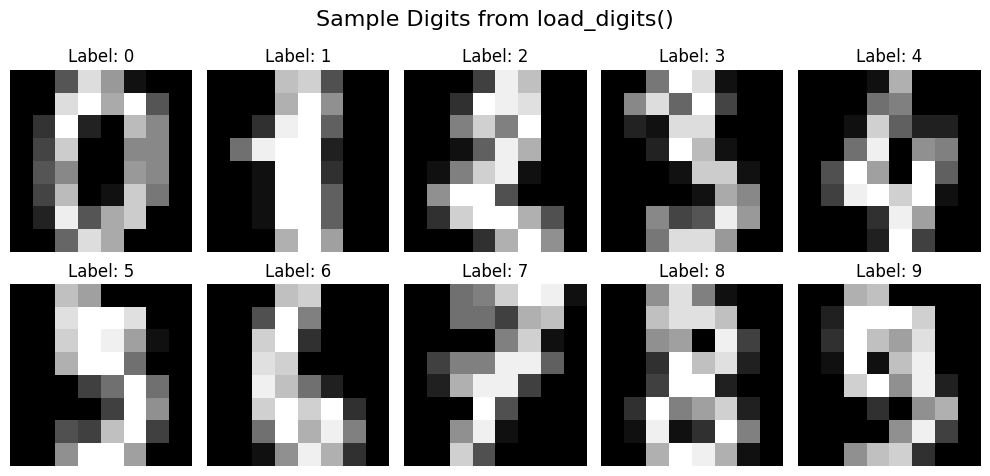

In [22]:
# Plot 10 example images with their labels
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(f"Label: {y[i]}")
    ax.axis('off')
plt.suptitle("Sample Digits from load_digits()", fontsize=16)
plt.tight_layout()
plt.show()

In [23]:
# pixel info
print("Minimum pixel value:", np.min(X))
print("Maximum pixel value:", np.max(X))
print("Mean pixel value:", np.mean(X))

Minimum pixel value: 0.0
Maximum pixel value: 16.0
Mean pixel value: 4.884164579855314


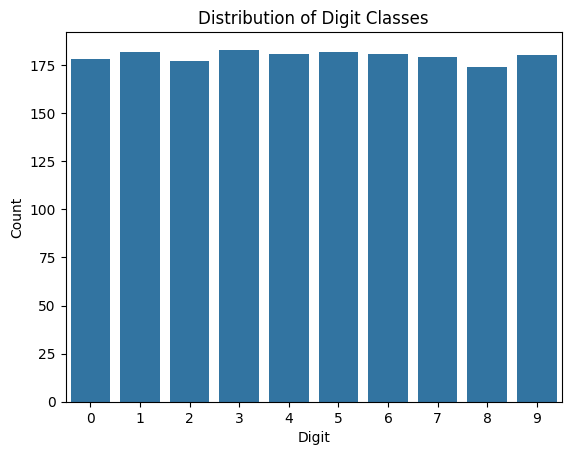

In [24]:
# check balance 
sns.countplot(x=y)
plt.title("Distribution of Digit Classes")
plt.xlabel("Digit")
plt.ylabel("Count")
plt.show()

- dataset nearly balanced

### `preprocessing`

In [28]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
# scale values of each pixel(each feature later after)
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


### `Train MLP`

In [30]:
# Train MLP on MNIST
mlp = MLPClassifier(
    hidden_layer_sizes=(256, 128, 64, 32),  # 3 hidden layers
    activation='relu',
    solver='adam',
    max_iter=1000,
    random_state=42
)

print("Training MLP on MNIST dataset...")
mlp.fit(X_train_scaled, y_train)

Training MLP on MNIST dataset...


MLPClassifier(hidden_layer_sizes=(256, 128, 64, 32), max_iter=1000,
              random_state=42)

### `Evalution`

In [31]:
y_pred = mlp.predict(X_test_scaled)
# Accuracy and Classification Report
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)

Accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        33
           1       0.97      1.00      0.98        28
           2       1.00      1.00      1.00        33
           3       1.00      0.97      0.99        34
           4       1.00      1.00      1.00        46
           5       0.94      0.96      0.95        47
           6       0.97      0.97      0.97        35
           7       0.97      0.97      0.97        34
           8       1.00      0.93      0.97        30
           9       0.95      0.97      0.96        40

    accuracy                           0.98       360
   macro avg       0.98      0.98      0.98       360
weighted avg       0.98      0.98      0.98       360



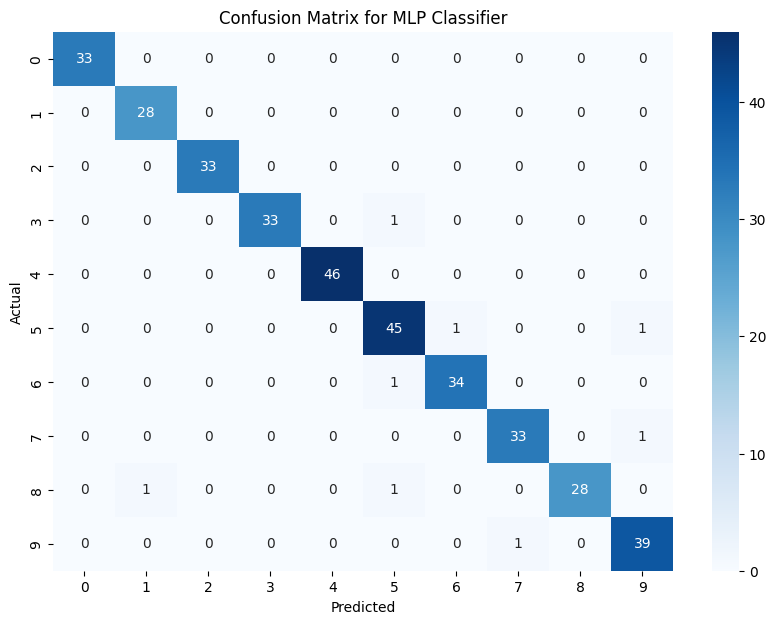

In [32]:
# plot cm
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=digits.target_names,
            yticklabels=digits.target_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for MLP Classifier')
plt.show()

### `UI creation using Gradio`

In [33]:
# Define prediction function for Gradio
def predict_digit(image):
    """
    Predict digit from drawn image
    """
    if image is None:
        return "Please draw a digit", {str(i): 0.0 for i in range(10)}
    
    # Handle different input types from Gradio
    if isinstance(image, dict):
        # If it's a dictionary, extract the image data
        if 'image' in image:
            image_data = image['image']
        elif 'composite' in image:
            image_data = image['composite']
        else:
            return "Invalid image format", {str(i): 0.0 for i in range(10)}
    else:
        image_data = image
    
    # Convert to PIL Image if it's not already
    if isinstance(image_data, np.ndarray):
        # Handle different array shapes
        if len(image_data.shape) == 3 and image_data.shape[2] == 4:  # RGBA
            image_pil = Image.fromarray(image_data, mode='RGBA')
        elif len(image_data.shape) == 3 and image_data.shape[2] == 3:  # RGB
            image_pil = Image.fromarray(image_data, mode='RGB')
        else:
            image_pil = Image.fromarray(image_data)
    elif isinstance(image_data, Image.Image):
        image_pil = image_data
    else:
        return "Unsupported image format", {str(i): 0.0 for i in range(10)}
    
    # Convert to grayscale
    image_pil = image_pil.convert('L')
    
    # Resize to 28x28 (MNIST size)
    image_pil = image_pil.resize((28, 28))
    
    # Convert to numpy array
    img_array = np.array(image_pil)
    
    # Invert colors (MNIST has white digits on black background)
    img_array = 255 - img_array
    
    # Normalize
    img_array = img_array.astype('float32') / 255.0
    
    # Flatten for MLP
    img_flat = img_array.reshape(1, -1)
    
    # Get prediction probabilities
    probabilities = mlp_mnist.predict_proba(img_flat)[0]
    
    # Get predicted class
    predicted_class = np.argmax(probabilities)
    
    # Create probability dictionary
    prob_dict = {str(i): float(probabilities[i]) for i in range(10)}
    
    return f"Predicted Digit: {predicted_class}", prob_dict

In [34]:
# Create and launch Gradio interface
def create_gradio_interface():
    """
    Create Gradio interface for digit recognition
    """
    # Create the interface
    interface = gr.Interface(
        fn=predict_digit,
        inputs=gr.Sketchpad(
            canvas_size=(280, 280),
            label="Draw a digit (0-9)"
        ),
        outputs=[
            gr.Textbox(label="Prediction"),
            gr.Label(num_top_classes=10, label="Probability for each class")
        ],
        title="🔢 Handwritten Digit Recognition",
        description="Draw a digit (0-9) in the box above and get the model's prediction with probabilities for all classes.",
        examples=None,
        live=False,  # Changed to False to avoid constant updates
        theme=gr.themes.Soft()
    )
    
    return interface

In [35]:
# Launch the interface
if __name__ == "__main__":
    # Create and launch the interface
    demo = create_gradio_interface()
    
    # Launch with public link (set share=False for local only)
    demo.launch(
        share=True,  # Set to False for local only
        debug=True,
        server_name="0.0.0.0",  # Allow external connections
    )

* Running on local URL:  http://0.0.0.0:7873

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


Keyboard interruption in main thread... closing server.
